# Preprocessing

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.stats as stats
import matplotlib.ticker as tick
import sklearn.model_selection

from operator import itemgetter
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)
import xgboost as xgb

import featuretools as ft
from sklearn import neighbors, datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

In [11]:
df = pd.read_csv('ny_eda_data.csv')
edf = df
df.dtypes

City                      object
address/streetAddress     object
ZipCode                  float64
latitude                 float64
livingArea               float64
longitude                float64
price                    float64
priceChangeRate          float64
propertyTaxRate          float64
HomeType                  object
YearBuilt                float64
ParkingType               object
Full_Bathrooms           float64
Half_Bathrooms           float64
Bedrooms                 float64
Lot_Size                 float64
Story_Building           float64
Annual_Tax               float64
Tax_Assessed_Value       float64
school_1_distance        float64
school_1_grades           object
school_1_level            object
school_1_rating          float64
school_1_size            float64
school_1_s/t_ratio       float64
school_1_type             object
school_2_distance        float64
school_2_level            object
school_2_rating          float64
school_2_size            float64
school_2_s

In [3]:
df = df.drop(['City','address/streetAddress', 'ParkingType', 'school_1_level', 'school_1_grades',
              'school_2_level', 'school_1_type', 'school_2_type'], axis=1) 

In [4]:
counts = df.HomeType.value_counts()
mask = df.HomeType.isin(counts[counts < 130].index)
df.HomeType[mask] = 'Other'
r_mask = df[df['HomeType'] == 'Residential Income']['HomeType'].index
df.HomeType[r_mask] = 'Residential'
df.HomeType = pd.Categorical(df.HomeType)
df.HomeType = df.HomeType.cat.codes

In [5]:
print(df.shape)
print(df.describe())

(62456, 24)
            ZipCode      latitude     livingArea     longitude         price  \
count  62449.000000  62455.000000   55035.000000  62455.000000  6.245600e+04   
mean   10902.516630     40.694577    3378.404379    -73.930004  9.250491e+05   
std      515.536308      0.095875   18247.884500      0.135142  9.186984e+05   
min      148.000000     40.498634       1.000000    -74.255333  1.000000e+05   
25%    10314.000000     40.614168    1300.000000    -74.001343  5.050000e+05   
50%    11209.000000     40.692322    1813.000000    -73.905731  6.972275e+05   
75%    11367.000000     40.756136    2530.000000    -73.829376  9.750000e+05   
max    13277.000000     40.912682  986641.000000    -73.700432  1.000000e+07   

       priceChangeRate  propertyTaxRate      HomeType     YearBuilt  \
count     6.199000e+04     62443.000000  62456.000000  58506.000000   
mean      4.768525e+02         0.826273      3.481107   1947.972926   
std       1.938993e+04         0.097421      1.610637 

array([[<AxesSubplot:title={'center':'ZipCode'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'livingArea'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'priceChangeRate'}>,
        <AxesSubplot:title={'center':'propertyTaxRate'}>,
        <AxesSubplot:title={'center':'HomeType'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'Full_Bathrooms'}>],
       [<AxesSubplot:title={'center':'Half_Bathrooms'}>,
        <AxesSubplot:title={'center':'Bedrooms'}>,
        <AxesSubplot:title={'center':'Lot_Size'}>,
        <AxesSubplot:title={'center':'Story_Building'}>,
        <AxesSubplot:title={'center':'Annual_Tax'}>],
       [<AxesSubplot:title={'center':'Tax_Assessed_Value'}>,
        <AxesSubplot:title={'center':'school_1_distance'}>,
        <AxesSubplot:title={'center':'school_1_rating'}>,
        <AxesSubplo

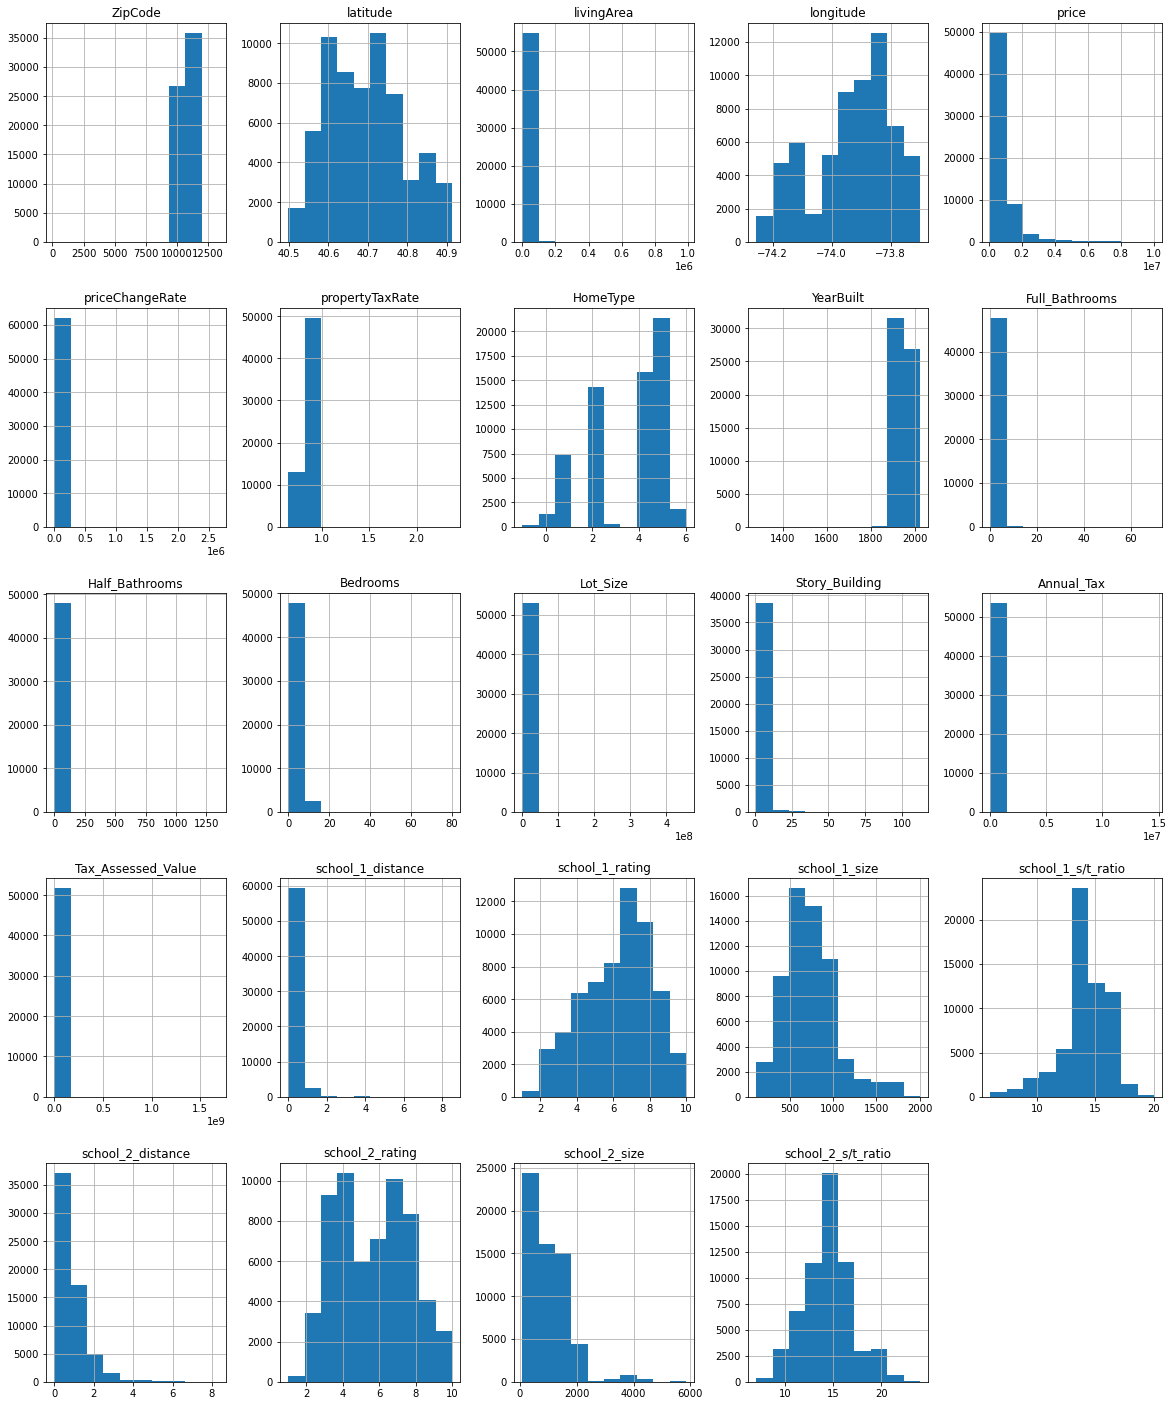

In [6]:
# Let's check the distribution of our features to better understand a better type of imputation
fig = plt.figure(figsize = (20,25))
ax = fig.gca()
df.hist(ax = ax)

In [7]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count', '%'])

,count,%
price,0,0.000000
HomeType,0,0.000000
latitude,1,0.001601
longitude,1,0.001601
ZipCode,7,0.011208
propertyTaxRate,13,0.020815
school_1_distance,85,0.136096
priceChangeRate,466,0.746125
school_1_size,473,0.757333
school_2_distance,706,1.130396


In [8]:
df.dtypes

ZipCode               float64
latitude              float64
livingArea            float64
longitude             float64
price                 float64
priceChangeRate       float64
propertyTaxRate       float64
HomeType                 int8
YearBuilt             float64
Full_Bathrooms        float64
Half_Bathrooms        float64
Bedrooms              float64
Lot_Size              float64
Story_Building        float64
Annual_Tax            float64
Tax_Assessed_Value    float64
school_1_distance     float64
school_1_rating       float64
school_1_size         float64
school_1_s/t_ratio    float64
school_2_distance     float64
school_2_rating       float64
school_2_size         float64
school_2_s/t_ratio    float64
dtype: object

In [9]:
X = df.drop(['price'] ,axis=1)
y = df.price

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

In [101]:
def mice_imputation_numeric(X_train, X_test):
    """
    Impute numeric data using MICE imputation with Gradient Boosting Regressor.
    """
    iter_imp_numeric = IterativeImputer(GradientBoostingRegressor())
    imputed_X_train = iter_imp_numeric.fit_transform(X_train)
    imputed_X_test = iter_imp_numeric.transform(X_test)
    X_train_imp = pd.DataFrame(imputed_X_train, columns = X_train.columns, index= X_train.index)
    X_test_imp = pd.DataFrame(imputed_X_test, columns = X_test.columns, index = X_test.index)
    return X_train_imp, X_test_imp



In [102]:
X_train_imp, X_test_imp = mice_imputation_numeric(X_train,X_test)


In [131]:
X_train = X_train_imp
X_test = X_test_imp

In [ ]:
X_train.to_csv(r'C:\Users\izine\Desktop\GitHub\Springboard-Data-Science\Capstone 2\Data\X_train.csv', index=False)
X_test.to_csv(r'C:\Users\izine\Desktop\GitHub\Springboard-Data-Science\Capstone 2\Data\X_train.csv', index=False)


In [104]:
# def standard_scale(train, test):
#     """
#     Built - in function to normalize data.
#     """
#     ss = StandardScaler()
#     xx_train, y_train = X_train[X_train.columns[:-1]], X_train[X_train.columns[-1]]
#     xx_train = pd.DataFrame(ss.fit_transform(xx_train),columns=xx_train.columns,index=xx_train.index)
#     test = pd.DataFrame(ss.transform(X_test),columns=X_test.columns,index=X_test.index)
#     return x_train, y_train, test

# x_train, y_train, test =standard_scale(X_train, X_test)

In [105]:
gb = xgb.XGBRegressor()

gb.fit(X_train, y_train)
pred_test = gb.predict(X_test)
pred_train = gb.predict(X_train)

In [106]:
print("R2 of Y_train  GB prediction's:", r2_score(y_train, pred_train))
print("R2 of Y_test  GB prediction's:",r2_score(y_test, pred_test))
print("MAE of Y_train GB prediction's:",mean_absolute_error(y_train, pred_train))
print("MAE of Y_test GB prediction's:",mean_absolute_error(y_test, pred_test))

R2 of Y_train  GB prediction's: 0.9095537591235316
R2 of Y_test  GB prediction's: 0.6867657628522341
MAE of Y_train GB prediction's: 155618.63458995652
MAE of Y_test GB prediction's: 220408.24968518913


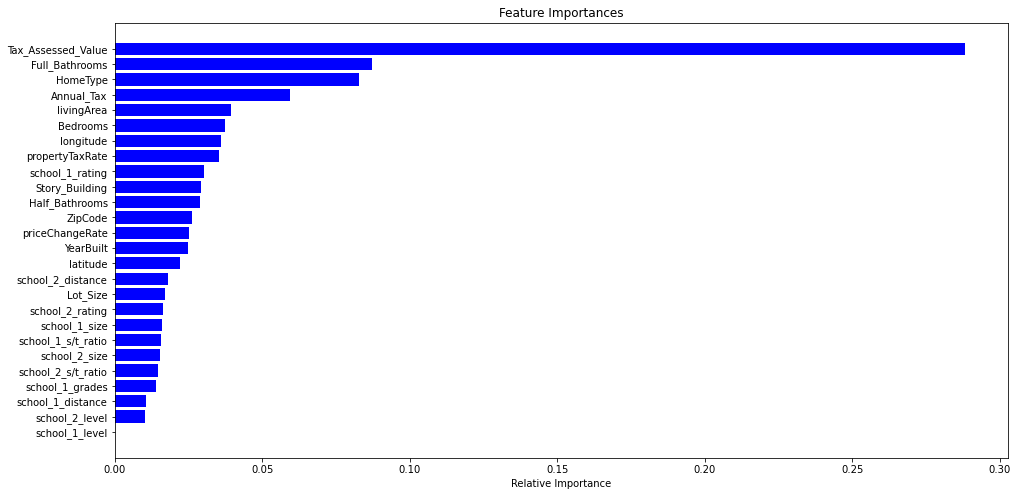

In [107]:
features = X_train.columns
importances = gb.feature_importances_
indices = np.argsort(importances)[-26:] 
plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [108]:
log_cols=['livingArea', 'Lot_Size', 'Tax_Assessed_Value']

In [109]:
X_train[log_cols] = np.log(X_train[log_cols])
X_test[log_cols] = np.log(X_test[log_cols])


In [130]:
X_train_imp.isnull().sum()

ZipCode                  0
latitude                 0
livingArea               6
longitude                0
priceChangeRate          0
propertyTaxRate          0
HomeType                 0
YearBuilt                0
Full_Bathrooms           0
Half_Bathrooms           0
Bedrooms                 0
Lot_Size              2120
Story_Building           0
Annual_Tax               0
Tax_Assessed_Value      37
school_1_distance        0
school_1_grades          0
school_1_level           0
school_1_rating          0
school_1_size            0
school_1_s/t_ratio       0
school_1_type            0
school_2_distance        0
school_2_level           0
school_2_rating          0
school_2_size            0
school_2_s/t_ratio       0
school_2_type            0
dtype: int64

In [135]:
ss = StandardScaler()

X_train = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(ss.transform(X_test),columns=X_test.columns,index=X_test.index)

In [137]:
feature_names = X_train.columns

log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

dtrain = xgb.DMatrix(X_train, label=log_y_train, feature_names=feature_names)

dtest = xgb.DMatrix(X_test, label=log_y_test, feature_names=feature_names)


In [138]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}


In [139]:
params['eval_metric'] = "mae"
num_boost_round = 999
evallist  = [(X_test,'eval'), (X_train,'train')]


In [140]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-mae:9.10164
[1]	Test-mae:6.37287
[2]	Test-mae:4.46246
[3]	Test-mae:3.12468
[4]	Test-mae:2.18831
[5]	Test-mae:1.53531
[6]	Test-mae:1.08300
[7]	Test-mae:0.77523
[8]	Test-mae:0.56998
[9]	Test-mae:0.43618
[10]	Test-mae:0.35129
[11]	Test-mae:0.29926
[12]	Test-mae:0.26905
[13]	Test-mae:0.25132
[14]	Test-mae:0.24078
[15]	Test-mae:0.23475
[16]	Test-mae:0.23104
[17]	Test-mae:0.22869
[18]	Test-mae:0.22692
[19]	Test-mae:0.22562
[20]	Test-mae:0.22436
[21]	Test-mae:0.22371
[22]	Test-mae:0.22266
[23]	Test-mae:0.22144
[24]	Test-mae:0.22109
[25]	Test-mae:0.22077
[26]	Test-mae:0.22034
[27]	Test-mae:0.21974
[28]	Test-mae:0.21945
[29]	Test-mae:0.21858
[30]	Test-mae:0.21829
[31]	Test-mae:0.21753
[32]	Test-mae:0.21738
[33]	Test-mae:0.21657
[34]	Test-mae:0.21646
[35]	Test-mae:0.21577
[36]	Test-mae:0.21558
[37]	Test-mae:0.21556
[38]	Test-mae:0.21521
[39]	Test-mae:0.21463
[40]	Test-mae:0.21414
[41]	Test-mae:0.21382
[42]	Test-mae:0.21369
[43]	Test-mae:0.21362
[44]	Test-mae:0.21359
[45]	Test-mae:0.2133

In [114]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=100,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,9.098053,0.000479,9.098279,0.001857
1,6.369709,0.000366,6.369660,0.000856
2,4.459876,0.000302,4.460152,0.000515
3,3.122869,0.000191,3.123638,0.001073
4,2.186955,0.000182,2.187517,0.001997
...,...,...,...,...
259,0.124230,0.000684,0.204511,0.002869
260,0.124033,0.000716,0.204504,0.002906
261,0.123867,0.000665,0.204498,0.002879
262,0.123669,0.000679,0.204503,0.002908


In [141]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,16)
    for min_child_weight in range(3,7)
]

In [142]:
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=100,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=6, min_child_weight=3
	MAE 0.20542160000000004 for 221 rounds
CV with max_depth=6, min_child_weight=4
	MAE 0.20616439999999997 for 155 rounds
CV with max_depth=6, min_child_weight=5
	MAE 0.20528619999999997 for 214 rounds
CV with max_depth=6, min_child_weight=6
	MAE 0.2050998 for 188 rounds
CV with max_depth=7, min_child_weight=3
	MAE 0.205185 for 176 rounds
CV with max_depth=7, min_child_weight=4
	MAE 0.20605060000000003 for 113 rounds
CV with max_depth=7, min_child_weight=5
	MAE 0.205187 for 165 rounds
CV with max_depth=7, min_child_weight=6
	MAE 0.2052836 for 157 rounds
CV with max_depth=8, min_child_weight=3
	MAE 0.2052164 for 152 rounds
CV with max_depth=8, min_child_weight=4
	MAE 0.2047892 for 124 rounds
CV with max_depth=8, min_child_weight=5
	MAE 0.20564559999999998 for 124 rounds
CV with max_depth=8, min_child_weight=6
	MAE 0.2053722 for 120 rounds
CV with max_depth=9, min_child_weight=3
	MAE 0.20446620000000001 for 224 rounds
CV with max_depth=9, min_child_w

In [143]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

In [144]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [145]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=100,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 0.20446620000000001 for 224 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.20610279999999997 for 112 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.20617040000000003 for 98 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.2056678 for 153 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.20771260000000002 for 72 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.20700519999999994 for 78 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.2077762 for 75 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.2083624 for 62 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.2081266 for 85 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.2085028 for 83 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.20956039999999998 for 91 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.2106012 for 80 rounds
CV with subsample=0.7, colsample=1.0
	MAE 0.2110862 for 78 rounds
CV with subsample=0.7, colsample=0.9
	MAE 0.212724 for 60 rounds
CV with subsam

In [146]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

In [147]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=100,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

Wall time: 0 ns
CV with eta=0.3
Wall time: 0 ns
	MAE 0.20446620000000001 for 224 rounds

CV with eta=0.2
Wall time: 0 ns
	MAE 0.19796160000000002 for 277 rounds

CV with eta=0.1
Wall time: 0 ns
	MAE 0.1914864 for 865 rounds

CV with eta=0.05
Wall time: 0 ns
	MAE 0.19098779999999999 for 998 rounds

CV with eta=0.01
Wall time: 0 ns
	MAE 0.1971774 for 998 rounds

CV with eta=0.005
Wall time: 0 ns
	MAE 0.22840539999999998 for 998 rounds

Best params: 0.05, MAE: 0.19098779999999999


In [148]:
params['eta'] = best_params
params

{'max_depth': 9,
 'min_child_weight': 3,
 'eta': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae'}

In [149]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:12.34920
[1]	Test-mae:11.73208
[2]	Test-mae:11.14570
[3]	Test-mae:10.58880
[4]	Test-mae:10.05977
[5]	Test-mae:9.55710
[6]	Test-mae:9.07949
[7]	Test-mae:8.62582
[8]	Test-mae:8.19487
[9]	Test-mae:7.78544
[10]	Test-mae:7.39637
[11]	Test-mae:7.02676
[12]	Test-mae:6.67570
[13]	Test-mae:6.34220
[14]	Test-mae:6.02535
[15]	Test-mae:5.72438
[16]	Test-mae:5.43843
[17]	Test-mae:5.16668
[18]	Test-mae:4.90855
[19]	Test-mae:4.66330
[20]	Test-mae:4.43040
[21]	Test-mae:4.20918
[22]	Test-mae:3.99893
[23]	Test-mae:3.79916
[24]	Test-mae:3.60948
[25]	Test-mae:3.42924
[26]	Test-mae:3.25805
[27]	Test-mae:3.09538
[28]	Test-mae:2.94086
[29]	Test-mae:2.79407
[30]	Test-mae:2.65461
[31]	Test-mae:2.52212
[32]	Test-mae:2.39626
[33]	Test-mae:2.27671
[34]	Test-mae:2.16310
[35]	Test-mae:2.05520
[36]	Test-mae:1.95280
[37]	Test-mae:1.85562
[38]	Test-mae:1.76349
[39]	Test-mae:1.67605
[40]	Test-mae:1.59307
[41]	Test-mae:1.51431
[42]	Test-mae:1.43968
[43]	Test-mae:1.36879
[44]	Test-mae:1.30143
[45]	Test-mae:1

[361]	Test-mae:0.19403
[362]	Test-mae:0.19401
[363]	Test-mae:0.19399
[364]	Test-mae:0.19396
[365]	Test-mae:0.19393
[366]	Test-mae:0.19393
[367]	Test-mae:0.19391
[368]	Test-mae:0.19390
[369]	Test-mae:0.19387
[370]	Test-mae:0.19386
[371]	Test-mae:0.19385
[372]	Test-mae:0.19384
[373]	Test-mae:0.19382
[374]	Test-mae:0.19380
[375]	Test-mae:0.19380
[376]	Test-mae:0.19379
[377]	Test-mae:0.19377
[378]	Test-mae:0.19374
[379]	Test-mae:0.19373
[380]	Test-mae:0.19374
[381]	Test-mae:0.19373
[382]	Test-mae:0.19374
[383]	Test-mae:0.19373
[384]	Test-mae:0.19372
[385]	Test-mae:0.19370
[386]	Test-mae:0.19369
[387]	Test-mae:0.19368
[388]	Test-mae:0.19366
[389]	Test-mae:0.19363
[390]	Test-mae:0.19364
[391]	Test-mae:0.19361
[392]	Test-mae:0.19360
[393]	Test-mae:0.19358
[394]	Test-mae:0.19353
[395]	Test-mae:0.19352
[396]	Test-mae:0.19355
[397]	Test-mae:0.19355
[398]	Test-mae:0.19354
[399]	Test-mae:0.19355
[400]	Test-mae:0.19353
[401]	Test-mae:0.19350
[402]	Test-mae:0.19348
[403]	Test-mae:0.19347
[404]	Test-

[718]	Test-mae:0.19114
[719]	Test-mae:0.19112
[720]	Test-mae:0.19112
[721]	Test-mae:0.19112
[722]	Test-mae:0.19110
[723]	Test-mae:0.19110
[724]	Test-mae:0.19108
[725]	Test-mae:0.19108
[726]	Test-mae:0.19106
[727]	Test-mae:0.19105
[728]	Test-mae:0.19105
[729]	Test-mae:0.19105
[730]	Test-mae:0.19104
[731]	Test-mae:0.19103
[732]	Test-mae:0.19102
[733]	Test-mae:0.19102
[734]	Test-mae:0.19101
[735]	Test-mae:0.19101
[736]	Test-mae:0.19102
[737]	Test-mae:0.19102
[738]	Test-mae:0.19103
[739]	Test-mae:0.19102
[740]	Test-mae:0.19102
[741]	Test-mae:0.19102
[742]	Test-mae:0.19101
[743]	Test-mae:0.19099
[744]	Test-mae:0.19099
[745]	Test-mae:0.19098
[746]	Test-mae:0.19096
[747]	Test-mae:0.19094
[748]	Test-mae:0.19093
[749]	Test-mae:0.19094
[750]	Test-mae:0.19093
[751]	Test-mae:0.19092
[752]	Test-mae:0.19092
[753]	Test-mae:0.19092
[754]	Test-mae:0.19093
[755]	Test-mae:0.19092
[756]	Test-mae:0.19092
[757]	Test-mae:0.19091
[758]	Test-mae:0.19091
[759]	Test-mae:0.19091
[760]	Test-mae:0.19091
[761]	Test-

In [150]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:12.34920
[1]	Test-mae:11.73208
[2]	Test-mae:11.14570
[3]	Test-mae:10.58880
[4]	Test-mae:10.05977
[5]	Test-mae:9.55710
[6]	Test-mae:9.07949
[7]	Test-mae:8.62582
[8]	Test-mae:8.19487
[9]	Test-mae:7.78544
[10]	Test-mae:7.39637
[11]	Test-mae:7.02676
[12]	Test-mae:6.67570
[13]	Test-mae:6.34220
[14]	Test-mae:6.02535
[15]	Test-mae:5.72438
[16]	Test-mae:5.43843
[17]	Test-mae:5.16668
[18]	Test-mae:4.90855
[19]	Test-mae:4.66330
[20]	Test-mae:4.43040
[21]	Test-mae:4.20918
[22]	Test-mae:3.99893
[23]	Test-mae:3.79916
[24]	Test-mae:3.60948
[25]	Test-mae:3.42924
[26]	Test-mae:3.25805
[27]	Test-mae:3.09538
[28]	Test-mae:2.94086
[29]	Test-mae:2.79407
[30]	Test-mae:2.65461
[31]	Test-mae:2.52212
[32]	Test-mae:2.39626
[33]	Test-mae:2.27671
[34]	Test-mae:2.16310
[35]	Test-mae:2.05520
[36]	Test-mae:1.95280
[37]	Test-mae:1.85562
[38]	Test-mae:1.76349
[39]	Test-mae:1.67605
[40]	Test-mae:1.59307
[41]	Test-mae:1.51431
[42]	Test-mae:1.43968
[43]	Test-mae:1.36879
[44]	Test-mae:1.30143
[45]	Test-mae:1

[717]	Test-mae:0.19113
[718]	Test-mae:0.19114
[719]	Test-mae:0.19112
[720]	Test-mae:0.19112
[721]	Test-mae:0.19112
[722]	Test-mae:0.19110
[723]	Test-mae:0.19110
[724]	Test-mae:0.19108
[725]	Test-mae:0.19108
[726]	Test-mae:0.19106
[727]	Test-mae:0.19105
[728]	Test-mae:0.19105
[729]	Test-mae:0.19105
[730]	Test-mae:0.19104
[731]	Test-mae:0.19103
[732]	Test-mae:0.19102
[733]	Test-mae:0.19102
[734]	Test-mae:0.19101
[735]	Test-mae:0.19101
[736]	Test-mae:0.19102
[737]	Test-mae:0.19102
[738]	Test-mae:0.19103
[739]	Test-mae:0.19102
[740]	Test-mae:0.19102
[741]	Test-mae:0.19102
[742]	Test-mae:0.19101
[743]	Test-mae:0.19099
[744]	Test-mae:0.19099
[745]	Test-mae:0.19098
[746]	Test-mae:0.19096
[747]	Test-mae:0.19094
[748]	Test-mae:0.19093
[749]	Test-mae:0.19094
[750]	Test-mae:0.19093
[751]	Test-mae:0.19092
[752]	Test-mae:0.19092
[753]	Test-mae:0.19092
[754]	Test-mae:0.19093
[755]	Test-mae:0.19092
[756]	Test-mae:0.19092
[757]	Test-mae:0.19091
[758]	Test-mae:0.19091
[759]	Test-mae:0.19091
[760]	Test-

In [151]:
bmlog_pred_test = best_model.predict(dtest)
bmlog_pred_train = best_model.predict(dtrain)

In [152]:
print("MAE of Y_train log GB prediction with HP Tuning:",mean_absolute_error(log_y_train, bmlog_pred_train))
print("MAE of Y_test log GB prediction with HP Tuning:",mean_absolute_error(log_y_test, bmlog_pred_test))

MAE of Y_train log GB prediction with HP Tuning: 0.08523571271188284
MAE of Y_test log GB prediction with HP Tuning: 0.18994875064638964


<Figure size 144x144 with 0 Axes>

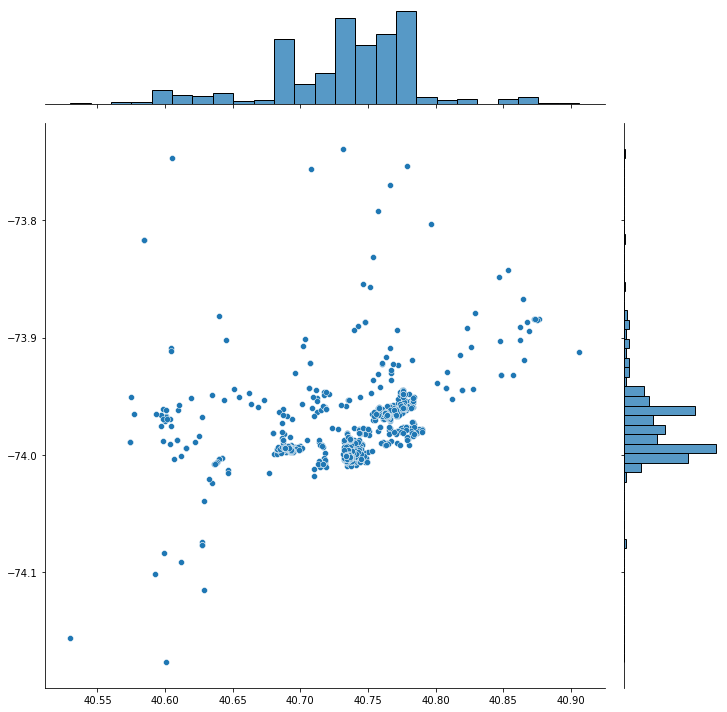

In [53]:
df100k = edf[edf.price <= 100000]
df100k_500k = edf[(edf.price > 100000) & (edf.price <= 500000)]
df500k_1m = edf[(edf.price > 500000) & (edf.price <= 1000000)]
df1m_5m = edf[(edf.price > 1000000) & (edf.price <= 5000000)]
df5m_10m = edf[(edf.price > 5000000) & (edf.price <= 10000000)]

plt.figure(figsize=(2,2))
sns.jointplot(x=df5m_10m.latitude.values, y=df5m_10m.longitude.values, height=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
## While there is some spread you can see that latitude and longitude helps with the indication of highly priced homes
## as a lot are packed together 

In [153]:
bm_pred_test = np.exp(bmlog_pred_test)
bm_pred_train = np.exp(bmlog_pred_train)

In [154]:
# Turning our prediction back to base numbers on which we did log
# Turning our prediction back to base numbers on which we did log

print("MAE of Y_train GB prediction with HP Tuning:",mean_absolute_error(y_train, bm_pred_train))

print("MAE of Y_test GB prediction with HP Tuning:",mean_absolute_error(y_test, bm_pred_test))


MAE of Y_train GB prediction with HP Tuning: 78526.16150440817
MAE of Y_test GB prediction with HP Tuning: 192720.71199630262


<AxesSubplot:>

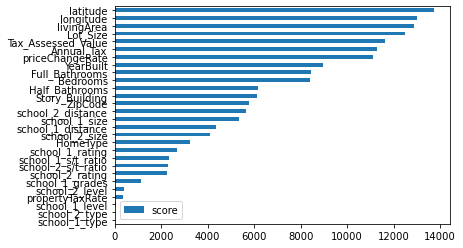

In [155]:
feature_important = best_model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score")
data.plot(kind='barh')

In [45]:
best_model.save_model("xgb_model.model")